<a href="https://colab.research.google.com/github/pmalaquias/BCC326_TP_PDI/blob/master/tp_pdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instala a API do Kaggle para baixar o dataset
!pip install kaggle

# Instala bibliotecas para processamento de dados e imagens
!pip install h5py scipy "opencv-python-headless<4.9"

# Força a instalação de uma versão do NumPy anterior à 2.0
!pip install "numpy<2"

In [ ]:
from google.colab import files

# Solicita o upload do arquivo kaggle.json
print("Por favor, faça o upload do seu arquivo 'kaggle.json'")
files.upload()

# Configura o diretório e as permissões
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixa o dataset MPIIGaze
print("\nBaixando o dataset...")
!kaggle datasets download -d dhruv413/mpiigaze

# Descompacta o dataset no diretório 'mpiigaze_dataset'
print("\nDescompactando o dataset...")
!unzip -q mpiigaze.zip -d mpiigaze_dataset
print("\nDownload e descompactação concluídos!")

Por favor, faça o upload do seu arquivo 'kaggle.json'


Saving kaggle.json to kaggle.json

Baixando o dataset...
Dataset URL: https://www.kaggle.com/datasets/dhruv413/mpiigaze
License(s): ODC Public Domain Dedication and Licence (PDDL)
100% 2.07G/2.08G [00:18<00:00, 238MB/s]
100% 2.08G/2.08G [00:18<00:00, 123MB/s]

Descompactando o dataset...

Download e descompactação concluídos!


In [ ]:
!pip install opencv-python-headless

In [ ]:
import cv2
print(cv2.__version__)

4.8.1


In [ ]:
# Procura pela localização exata dos arquivos .mat
!find /content/mpiigaze_dataset -name "*.mat"

/content/mpiigaze_dataset/MPIIGaze/Data/Original/p01/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p01/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p01/Calibration/monitorPose.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p00/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p00/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p00/Calibration/monitorPose.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p10/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p10/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p10/Calibration/monitorPose.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p09/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p09/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p09/Calibration/monitorPose.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p05

In [ ]:
# Este comando vai listar a localização de todos os arquivos .mat no dataset
print("Procurando por arquivos .mat... Por favor, copie a saída abaixo.")
!find /content/mpiigaze_dataset -name "*.mat"

Procurando por arquivos .mat... Por favor, copie a saída abaixo.
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p01/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p01/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p01/Calibration/monitorPose.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p00/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p00/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p00/Calibration/monitorPose.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p10/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p10/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p10/Calibration/monitorPose.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p09/Calibration/screenSize.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p09/Calibration/Camera.mat
/content/mpiigaze_dataset/MPIIGaze/Data/Original/p09/Calibration/mon

In [ ]:
root_mpi_dir = "/content/mpiigaze_dataset/MPIIGaze"
data_dir = os.path.join(root_mpi_dir, 'Data')
annot_dir = os.path.join(root_mpi_dir, 'Annotation Subset')  # Annotation files directory
img_dir = os.path.join(data_dir, 'Original')  # Path to images

In [ ]:
import os
import cv2
import h5py
import numpy as np
import scipy.io

# --- Definição dos Caminhos FINAIS e CORRETOS ---
# 1. Caminho para os arquivos de anotação .mat
normalized_data_path = data_dir+"/Normalized/"

# 2. Caminho para os arquivos de imagem .jpg
original_data_path = "/content/mpiigaze_dataset/MPIIGaze/Data/Original/"

output_path = "/content/"

print("Iniciando o processamento com os caminhos corretos para .mat e .jpg...")

with h5py.File(os.path.join(output_path, "MPIIGaze.h5"), 'w') as out:
    for p_i in range(15):
        p_str = f"p{p_i:02d}"
        person_norm_path = os.path.join(normalized_data_path, p_str)

        if not os.path.isdir(person_norm_path):
            continue

        print(f"Processando pessoa: {p_str}")

        person_left_images, person_left_gaze = [], []
        person_right_images, person_right_gaze = [], []

        day_files = [f for f in os.listdir(person_norm_path) if f.endswith('.mat')]

        for day_mat_file in day_files:
            mat_path = os.path.join(person_norm_path, day_mat_file)

            try:
                mat_data = scipy.io.loadmat(mat_path)

                left_eye_data = mat_data['data']['left'][0, 0]
                right_eye_data = mat_data['data']['right'][0, 0]
                image_filenames = mat_data['filenames']

            except Exception as e:
                print(f"  !! ERRO ao ler o arquivo .mat '{day_mat_file}': {e}")
                continue

            # Extrai o nome da pasta do dia (ex: 'day01') do nome do arquivo .mat
            day_folder_name = os.path.splitext(day_mat_file)[0]

            # Processa olho esquerdo
            for i in range(len(left_eye_data['gaze'][0, 0])):
                image_filename_str = image_filenames[i][0][0]
                # Constrói o caminho da imagem usando a pasta Original e a pasta do dia
                image_path = os.path.join(original_data_path, p_str, day_folder_name, image_filename_str)

                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    # As imagens originais são grandes, vamos redimensioná-las para 60x36
                    image_resized = cv2.resize(image, (60, 36))
                    image_resized = cv2.equalizeHist(image_resized)
                    image_resized = image_resized.astype(np.float32) / 255.0
                    person_left_images.append(image_resized)
                    person_left_gaze.append(left_eye_data['gaze'][0, 0][i])

            # Processa olho direito (lógica idêntica)
            for i in range(len(right_eye_data['gaze'][0, 0])):
                image_filename_str = image_filenames[i][0][0]
                image_path = os.path.join(original_data_path, p_str, day_folder_name, image_filename_str)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    image_resized = cv2.resize(image, (60, 36))
                    image_resized = cv2.equalizeHist(image_resized)
                    image_resized = image_resized.astype(np.float32) / 255.0
                    person_right_images.append(image_resized)
                    person_right_gaze.append(right_eye_data['gaze'][0, 0][i])

        if person_left_images:
            print(f"  -> Sucesso! Salvando {len(person_left_images)} imagens para {p_str}")
            person_group = out.create_group(p_str)
            person_group.create_dataset("left_eye", data=np.array(person_left_images).reshape(-1, 36, 60, 1))
            person_group.create_dataset("left_gaze", data=np.array(person_left_gaze))
            person_group.create_dataset("right_eye", data=np.array(person_right_images).reshape(-1, 36, 60, 1))
            person_group.create_dataset("right_gaze", data=np.array(person_right_gaze))
        else:
            print(f"  !! Nenhum dado foi processado com sucesso para {p_str}")

print("\nProcessamento concluído com sucesso!")
print(f"O dataset processado foi salvo em: {os.path.join(output_path, 'MPIIGaze.h5')}")

Iniciando o processamento com os caminhos corretos para .mat e .jpg...
Processando pessoa: p00
  -> Sucesso! Salvando 29961 imagens para p00
Processando pessoa: p01
  -> Sucesso! Salvando 24143 imagens para p01
Processando pessoa: p02
  -> Sucesso! Salvando 28019 imagens para p02
Processando pessoa: p03
  -> Sucesso! Salvando 35075 imagens para p03
Processando pessoa: p04
  -> Sucesso! Salvando 16831 imagens para p04
Processando pessoa: p05
  -> Sucesso! Salvando 16577 imagens para p05
Processando pessoa: p06
  -> Sucesso! Salvando 18448 imagens para p06
Processando pessoa: p07
  -> Sucesso! Salvando 15509 imagens para p07
Processando pessoa: p08
  -> Sucesso! Salvando 10701 imagens para p08
Processando pessoa: p09
  -> Sucesso! Salvando 7995 imagens para p09
Processando pessoa: p10
  -> Sucesso! Salvando 2810 imagens para p10
Processando pessoa: p11
  -> Sucesso! Salvando 2982 imagens para p11
Processando pessoa: p12
  -> Sucesso! Salvando 1609 imagens para p12
Processando pessoa: p13

Pessoas no dataset: ['p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14']

Dados disponíveis para p00: ['left_eye', 'left_gaze', 'right_eye', 'right_gaze']

Formato do array de imagens (olho esquerdo): (29961, 36, 60, 1)
Formato do array de 'gaze' (olho esquerdo): (29961, 3)

Vetor de gaze para a imagem de exemplo: [-0.22758145  0.22961674 -0.94629955]


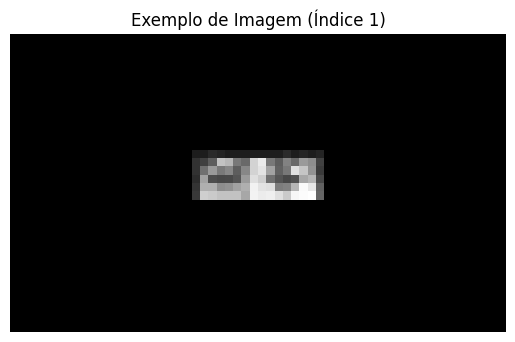

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Abra o arquivo HDF5 que você criou (em modo de leitura 'r')
with h5py.File('MPIIGaze.h5', 'r') as hf:
    # Liste todas as pessoas (grupos) no arquivo
    print("Pessoas no dataset:", list(hf.keys()))

    # Vamos pegar os dados da primeira pessoa (p00) como exemplo
    p00 = hf['p00']

    # Veja os datasets disponíveis para a pessoa p00
    print("\nDados disponíveis para p00:", list(p00.keys()))

    # Carregue os dados em arrays NumPy
    imagens_olho_esquerdo = p00['left_eye'][:]
    gaze_olho_esquerdo = p00['left_gaze'][:]

    print("\nFormato do array de imagens (olho esquerdo):", imagens_olho_esquerdo.shape)
    print("Formato do array de 'gaze' (olho esquerdo):", gaze_olho_esquerdo.shape)

    # Vamos visualizar uma imagem e seu vetor de gaze correspondente
    indice_exemplo = 1
    imagem_exemplo = imagens_olho_esquerdo[indice_exemplo].squeeze() # Remove a dimensão do canal
    gaze_exemplo = gaze_olho_esquerdo[indice_exemplo]

    print(f"\nVetor de gaze para a imagem de exemplo: {gaze_exemplo}")

    plt.imshow(imagem_exemplo, cmap='gray')
    plt.title(f'Exemplo de Imagem (Índice {indice_exemplo})')
    plt.axis('off')
    plt.show()

In [ ]:
# Listas para guardar todos os dados de treino e validação
X_train, y_train = [], []
X_val, y_val = [], []

# Pessoas para validação (ex: p13 e p14)
pessoas_validacao = ['p13', 'p14']

with h5py.File('MPIIGaze.h5', 'r') as hf:
    for p_str in hf.keys():
        # Pega as imagens e os vetores de gaze (vamos usar apenas o olho esquerdo por simplicidade)
        imagens = hf[p_str]['left_eye'][:]
        gazes = hf[p_str]['left_gaze'][:]

        if p_str in pessoas_validacao:
            X_val.append(imagens)
            y_val.append(gazes)
        else:
            X_train.append(imagens)
            y_train.append(gazes)

# Concatena os dados de todas as pessoas em um único array
X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_val = np.vstack(X_val)
y_val = np.vstack(y_val)

print("Formato dos dados de TREINO:")
print("Imagens (X_train):", X_train.shape)
print("Gaze (y_train):", y_train.shape)
print("\nFormato dos dados de VALIDAÇÃO:")
print("Imagens (X_val):", X_val.shape)
print("Gaze (y_val):", y_val.shape)

Formato dos dados de TREINO:
Imagens (X_train): (210660, 36, 60, 1)
Gaze (y_train): (210660, 3)

Formato dos dados de VALIDAÇÃO:
Imagens (X_val): (2998, 36, 60, 1)
Gaze (y_val): (2998, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir a arquitetura do modelo
modelo = Sequential([
    # Camada de Convolução 1: Extrai características iniciais (bordas, texturas)
    # 32 filtros, kernel 3x3, função de ativação 'relu'
    Conv2D(32, (3, 3), activation='relu', input_shape=(36, 60, 1)),
    MaxPooling2D((2, 2)), # Reduz a dimensão da imagem

    # Camada de Convolução 2: Extrai características mais complexas
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Achata os dados para entrar na parte densa da rede
    Flatten(),

    # Camada Densa: Aprende as combinações das características
    Dense(64, activation='relu'),
    Dropout(0.5), # Técnica para evitar overfitting

    # Camada de Saída: Prediz os 2 valores do vetor de gaze (pitch e yaw)
    Dense(2)
])

# Compilar o modelo
# Otimizador 'adam' é uma boa escolha padrão.
# A perda 'mean_squared_error' é usada para problemas de regressão (prever valores contínuos).
modelo.compile(optimizer='adam', loss='mean_squared_error')

# Exibe um resumo da arquitetura do modelo
modelo.summary()

# Treinar o modelo!
print("\nIniciando o treinamento do modelo...")
historico = modelo.fit(
    X_train, y_train,
    epochs=10,  # Número de vezes que o modelo verá todo o dataset
    batch_size=128, # Número de amostras por atualização do gradiente
    validation_data=(X_val, y_val)
)
print("Treinamento concluído!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 34, 58, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 17, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 13, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5824)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       372,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,746 (1.49 MB)

 Trainable params: 391,746 (1.49 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento do modelo...
Epoch 1/10


ValueError: Dimensions must be equal, but are 3 and 2 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, sequential_1/dense_1_2/BiasAdd)' with input shapes: [?,3], [?,2].

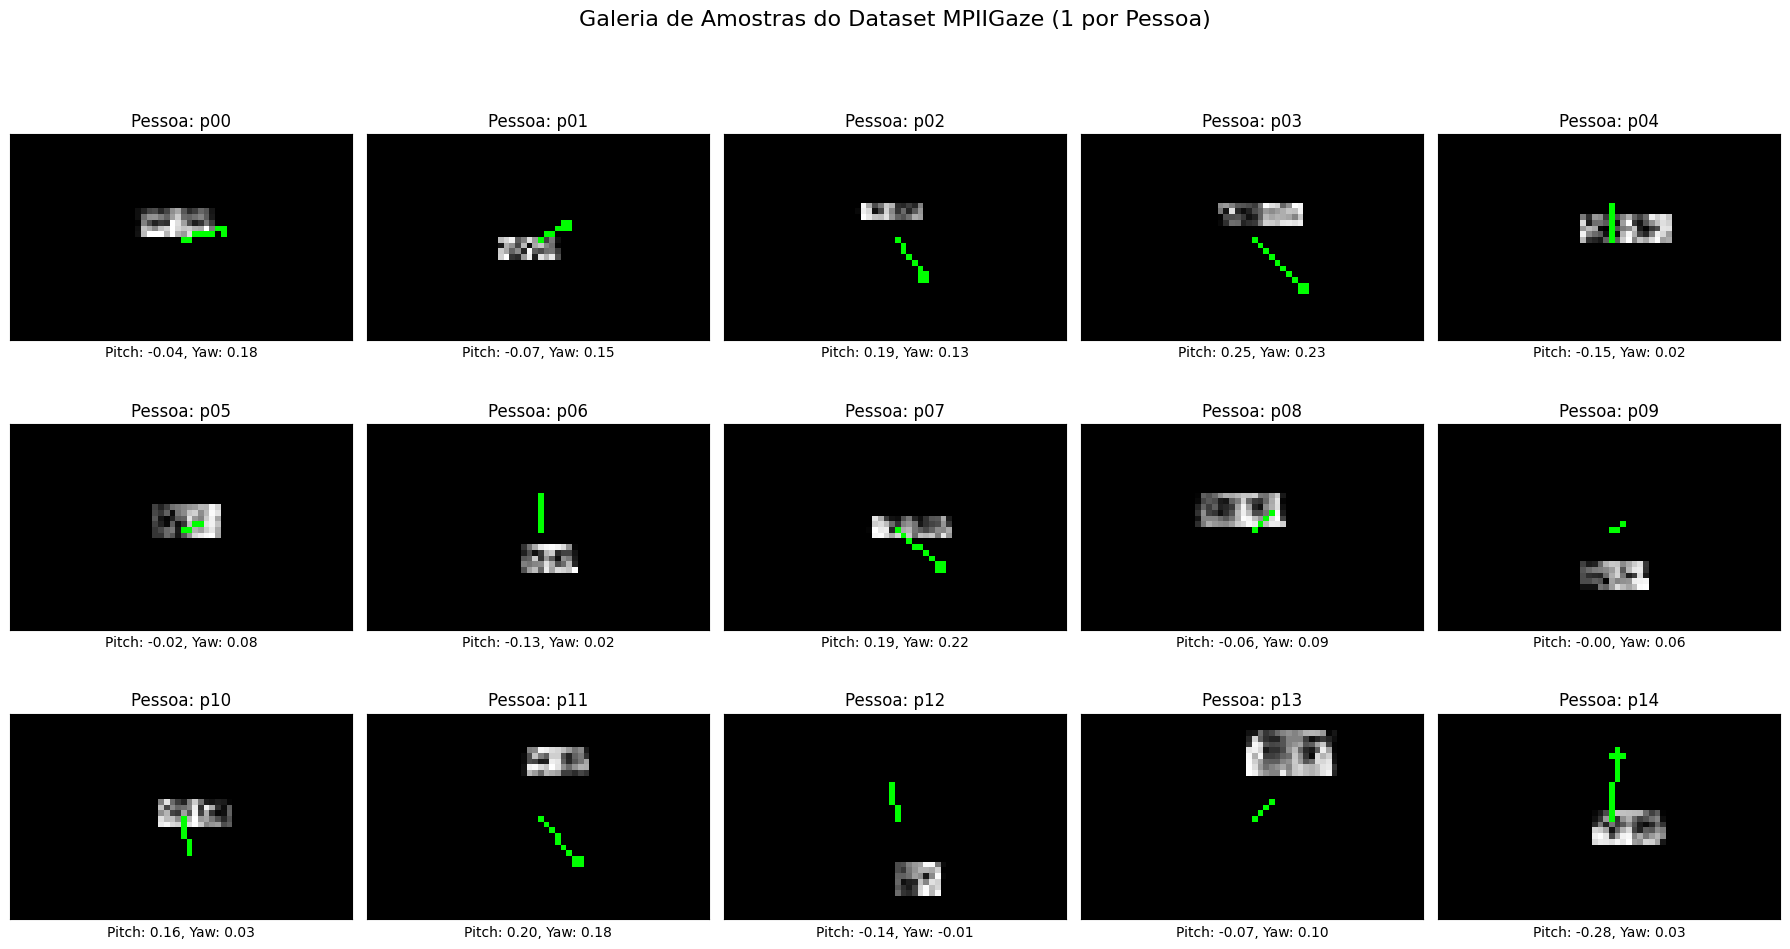

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Usaremos o OpenCV para desenhar a seta
import math

# Abre o arquivo HDF5 que você criou
h5_path = 'MPIIGaze.h5'
try:
    with h5py.File(h5_path, 'r') as hf:
        # Cria uma grade de plots (3 linhas, 5 colunas) para as 15 pessoas
        fig, axes = plt.subplots(3, 5, figsize=(18, 10))
        fig.suptitle('Galeria de Amostras do Dataset MPIIGaze (1 por Pessoa)', fontsize=16)

        # Achatamos o array de eixos para facilitar o loop
        axes = axes.flatten()

        # Pega a lista de pessoas (p00, p01, etc.) e a ordena
        person_keys = sorted(list(hf.keys()))

        # Itera sobre cada pessoa e seu respectivo eixo de plotagem
        for i, p_str in enumerate(person_keys):
            ax = axes[i]
            person_data = hf[p_str]

            # Pega uma imagem de exemplo do meio do dataset da pessoa
            # (usando o olho esquerdo como exemplo)
            num_images = len(person_data['left_eye'])
            if num_images == 0:
                ax.set_title(f"{p_str}\n(Sem dados)")
                ax.axis('off')
                continue

            sample_index = num_images // 2 # Pega o índice do meio

            image = person_data['left_eye'][sample_index]
            gaze = person_data['left_gaze'][sample_index]

            # --- Preparação para desenhar ---
            # Converte a imagem de (36, 60, 1) para uma imagem BGR (colorida) para podermos desenhar com cor
            image_bgr = (image.squeeze() * 255).astype(np.uint8)
            image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_GRAY2BGR)

            # --- Calcula o vetor de gaze para desenhar a seta ---
            # Ponto de início da seta (centro do olho)
            start_point = (30, 18) # Metade de (60, 36)

            # O vetor de gaze tem 2 valores: [pitch, yaw] em radianos
            pitch = gaze[0]
            yaw = gaze[1]

            # Converte os ângulos de pitch/yaw para um ponto final (x, y) na imagem
            # Usamos trigonometria para "projetar" o vetor 3D na imagem 2D
            arrow_length = 40.0
            end_x = int(start_point[0] + arrow_length * math.sin(yaw))
            end_y = int(start_point[1] + arrow_length * math.sin(pitch))

            # Desenha a seta na imagem
            cv2.arrowedLine(image_bgr, start_point, (end_x, end_y), (0, 255, 0), 1) # Seta verde

            # --- Mostra a imagem ---
            ax.imshow(image_bgr)
            ax.set_title(f"Pessoa: {p_str}")
            ax.set_xlabel(f"Pitch: {pitch:.2f}, Yaw: {yaw:.2f}")
            ax.set_xticks([])
            ax.set_yticks([])

        # Desliga os eixos que não foram usados (caso hajam menos de 15 pessoas)
        for i in range(len(person_keys), len(axes)):
            axes[i].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para o título principal
        plt.show()

except FileNotFoundError:
    print(f"Erro: O arquivo '{h5_path}' não foi encontrado. Certifique-se de que o passo de processamento foi concluído com sucesso.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")
    print("Verifique se o seu arquivo H5 não está vazio. Se a etapa anterior resultou em 'Nenhum dado encontrado', você precisará executá-la novamente com o código corrigido.")

In [ ]:
import os
import glob
import pandas as pd
from pathlib import Path
from IPython.display import display
import numpy as np

# --- 1. Definição dos caminhos (sem alteração) ---
base_dir = "/content/mpiigaze_dataset/MPIIGaze/"
annot_dir = os.path.join(base_dir, "Evaluation Subset/")
img_dir = os.path.join(base_dir, "Data/Original/")


# --- 2. Função 'read_annot' (a versão robusta está correta, sem alteração) ---
def read_annot(in_path):
    participant_id = Path(in_path).stem
    records = []

    with open(in_path, 'r') as f:
        for line_num, line in enumerate(f, 1):
            parts = line.strip().split()
            if not parts:
                continue

            image_file = parts[0]
            coords = parts[1:]
            row_data = {'path': image_file}

            num_points = len(coords) // 2
            for i in range(num_points):
                try:
                    x_val = float(coords[i*2])
                    y_val = float(coords[i*2 + 1])
                except ValueError:
                    print(f"Aviso: Dado inválido encontrado no arquivo '{Path(in_path).name}' na linha {line_num}. Usando NaN.")
                    x_val = np.nan
                    y_val = np.nan

                row_data[f'x{i}'] = x_val
                row_data[f'y{i}'] = y_val

            records.append(row_data)

    df = pd.DataFrame(records)

    if df.empty:
        return pd.DataFrame()

    df["path"] = df["path"].apply(lambda x: os.path.join(img_dir, participant_id, x))
    df["group"] = participant_id
    df["exists"] = df["path"].apply(os.path.exists)

    return df

# --- 3. Processa todos os arquivos .txt (COM BUSCA RECURSIVA) ---
# CORREÇÃO AQUI: Adicionado '**/' e 'recursive=True' para buscar em subpastas
annot_files = glob.glob(os.path.join(annot_dir, "**/p??.txt"), recursive=True)

print(f"Arquivos de anotação encontrados para processar: {[Path(f).name for f in annot_files]}")

# Verifica se a lista de arquivos não está vazia antes de concatenar
if not annot_files:
    print("\nNenhum arquivo de anotação 'pXX.txt' foi encontrado nos diretórios. Verifique a estrutura das pastas.")
    all_annot_df = pd.DataFrame() # Cria um DataFrame vazio
else:
    all_annot_df = pd.concat([read_annot(file) for file in annot_files], ignore_index=True)

# Imprime um resumo
print(f"\nTotal de Anotações Encontradas: {all_annot_df.shape[0]}")
if not all_annot_df.empty:
    print(f"Imagens não encontradas: {100 - 100 * all_annot_df['exists'].mean():.2f}%")

    # Remove as linhas onde a imagem correspondente não foi encontrada
    all_annot_df = all_annot_df[all_annot_df["exists"]].drop("exists", axis=1)
    print(f"\nTotal de Anotações Válidas (com imagens existentes): {all_annot_df.shape[0]}")
else:
    print("O DataFrame de anotações está vazio.")


# --- 4. Salva o DataFrame final (sem alteração) ---
csv_path = "/content/mpiigaze_annotations.csv"
all_annot_df.to_csv(csv_path, index=False)
print(f"Anotações de landmarks salvas em: {csv_path}")


# --- 5. Mostra uma amostra aleatória (sem alteração) ---
if not all_annot_df.empty:
    print("\nAmostra das anotações processadas:")
    display(all_annot_df.sample(min(5, len(all_annot_df))))
else:
    print("\nNenhuma anotação válida foi encontrada para exibir uma amostra.")

Arquivos de anotação encontrados para processar: ['p11.txt', 'p05.txt', 'p13.txt', 'p03.txt', 'p12.txt', 'p06.txt', 'p04.txt', 'p10.txt', 'p14.txt', 'p02.txt', 'p07.txt', 'p01.txt', 'p08.txt', 'p09.txt', 'p00.txt', 'p11.txt', 'p05.txt', 'p13.txt', 'p03.txt', 'p12.txt', 'p06.txt', 'p04.txt', 'p10.txt', 'p14.txt', 'p02.txt', 'p07.txt', 'p01.txt', 'p08.txt', 'p09.txt', 'p00.txt']

Total de Anotações Encontradas: 82667
Imagens não encontradas: 0.00%

Total de Anotações Válidas (com imagens existentes): 82667
Anotações de landmarks salvas em: /content/mpiigaze_annotations.csv

Amostra das anotações processadas:


,path,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,group
29480,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...,551.0,471.0,594.0,471.0,682.0,473.0,727.0,475.0,578.0,611.0,687.0,614.0,p08
71840,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p01
27280,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...,508.0,423.0,562.0,430.0,669.0,435.0,721.0,434.0,539.0,586.0,673.0,594.0,p01
3991,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...,586.0,331.0,633.0,333.0,721.0,337.0,772.0,337.0,616.0,484.0,726.0,489.0,p05
27567,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...,402.0,197.0,451.0,200.0,554.0,200.0,609.0,197.0,440.0,348.0,564.0,349.0,p01


In [ ]:
csv_path = "/content/mpiigaze_annotations.csv"
df = pd.read_csv(csv_path)

print(f"Total Entries: {len(df)}")
print("Missing Values:\n", df.isnull().sum())

num_unique_images = df["path"].nunique()
print(f"Unique Image Paths: {num_unique_images}")

Total Entries: 82667
Missing Values:
 path         0
x0       45000
y0       45000
x1       45000
y1       45000
x2       45000
y2       45000
x3       45000
y3       45000
x4       45000
y4       45000
x5       45000
y5       45000
group        0
dtype: int64
Unique Image Paths: 37667


In [ ]:
print(df["group"].value_counts())
group_counts = df.groupby("group")["path"].nunique()
print(group_counts)

group
p03    5929
p00    5927
p02    5916
p01    5904
p06    5877
p05    5870
p04    5860
p07    5843
p08    5767
p09    5719
p11    5262
p10    5194
p12    4601
p14    4500
p13    4498
Name: count, dtype: int64
group
p00    2927
p01    2904
p02    2916
p03    2929
p04    2860
p05    2870
p06    2877
p07    2843
p08    2767
p09    2719
p10    2194
p11    2262
p12    1601
p13    1498
p14    1500
Name: path, dtype: int64


In [ ]:
df["exists"] = df["path"].apply(os.path.exists)

missing_count = df["exists"].value_counts()
print(missing_count)

missing_images = df[df["exists"] == False]["path"]
if not missing_images.empty:
    print("Missing image files:")
    print(missing_images.head())

exists
True    82667
Name: count, dtype: int64


Selected Participant: p08
Image Path: /content/mpiigaze_dataset/MPIIGaze/Data/Original/p08/day39/0540.jpg
X Coordinates: [509.0, 549.0, 627.0, 668.0, 537.0, 636.0]
Y Coordinates: [225.0, 224.0, 225.0, 227.0, 344.0, 346.0]


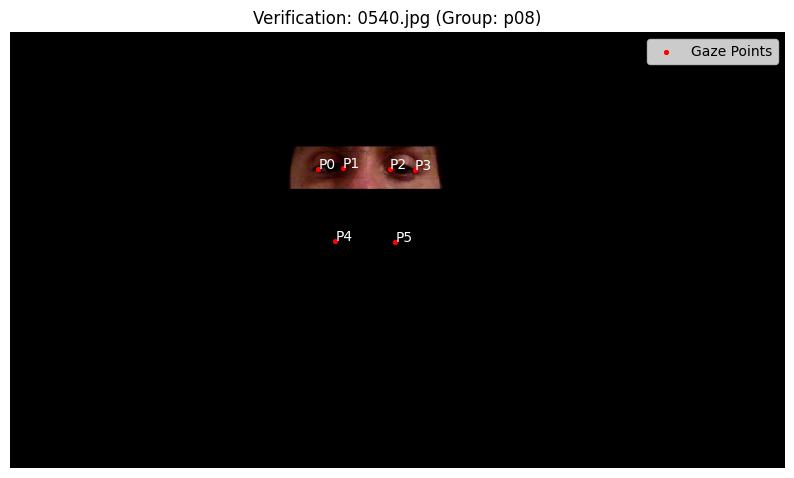

In [ ]:
random_participant = random.choice(df["group"].unique())
filtered_df = df[df["group"] == random_participant]
random_sample = filtered_df.sample(1)

# Extract the image path and gaze coordinates
img_path = random_sample["path"].values[0]
num_points = (len(df.columns) - 2) // 2
x_coords = [random_sample[f"x{i}"].values[0] for i in range(num_points)]
y_coords = [random_sample[f"y{i}"].values[0] for i in range(num_points)]

# Print the extracted coordinates
print(f"Selected Participant: {random_participant}")
print(f"Image Path: {img_path}")
print(f"X Coordinates: {x_coords}")
print(f"Y Coordinates: {y_coords}")

# Read and display the image with gaze points
if os.path.exists(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    h, w = img.shape[:2]

    # Plot image with gaze points
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.scatter(x_coords, y_coords, color='red', s=30, marker=".", label="Gaze Points")

    # Label each gaze point for clarity
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.text(x, y, f"P{i}", color='white', fontsize=10, ha='left', bbox=dict(facecolor='none', alpha=0.1))

    plt.title(f"Verification: {os.path.basename(img_path)} (Group: {random_participant})")
    plt.axis("off")
    plt.legend()
    plt.show()
else:
    print(f"Image not found: {img_path}")

Found Images:


,path
2276,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
2675,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
2769,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
3754,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
4030,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
4308,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
4586,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
4687,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
40833,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...
41762,/content/mpiigaze_dataset/MPIIGaze/Data/Origin...


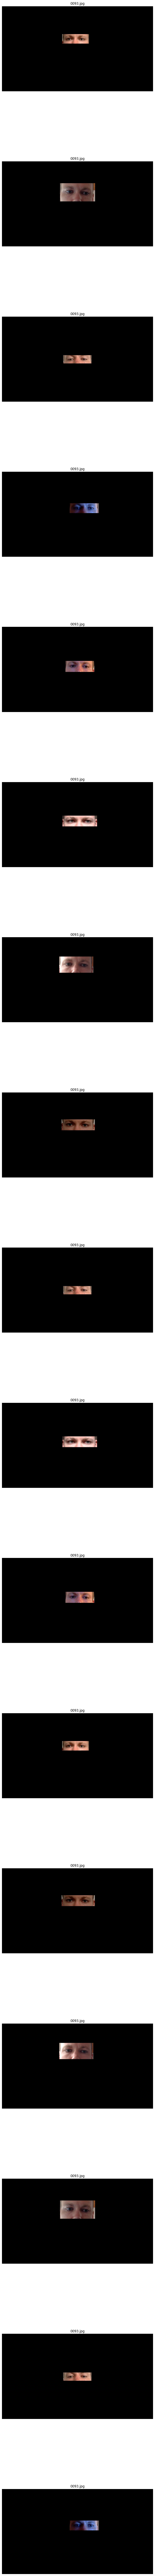

In [ ]:
group_id = "p05"
image_name = "0093.jpg"


verified_images = df[(df["group"] == group_id) & (df["path"].str.contains(image_name, case=False, na=False))]
print("Found Images:")
display(verified_images[["path"]])  # Show only the paths column

fig, axes = plt.subplots(len(verified_images), 1, figsize=(8, 8 * len(verified_images)))

if len(verified_images) == 1:
    axes = [axes]

for ax, img_path in zip(axes, verified_images["path"].values):
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path))
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()

In [ ]:
# Este código deve ser executado no Google Colab

import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Carregar e Preparar os Dados ---
X_train, y_train = [], []
X_val, y_val = [], []
pessoas_validacao = ['p13', 'p14']

with h5py.File('MPIIGaze.h5', 'r') as hf:
    for p_str in hf.keys():
        imagens = hf[p_str]['left_eye'][:]

        # --- CORREÇÃO AQUI ---
        # Seleciona apenas as duas primeiras colunas (pitch, yaw) dos dados de gaze
        gazes = hf[p_str]['left_gaze'][:, :2]

        if p_str in pessoas_validacao:
            X_val.append(imagens)
            y_val.append(gazes)
        else:
            X_train.append(imagens)
            y_train.append(gazes)

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_val = np.vstack(X_val)
y_val = np.vstack(y_val)

print("Dados de treino e validação prontos.")
print(f"Formato final de y_train: {y_train.shape}") # Deve ser (N, 2)

# --- Definir e Compilar o Modelo ---
modelo = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(36, 60, 1)),
    MaxPooling2D((2, 2)),
    # E aqui
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    # E menos neurônios aqui
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2)
])
modelo.compile(optimizer='adam', loss='mean_squared_error')
modelo.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- Treinar o Modelo ---
print("\nIniciando o treinamento...")
historico = modelo.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)
print("Treinamento concluído!")

# --- Salvar o Modelo Treinado ---
modelo.save('gaze_model.keras')
print("\nModelo salvo com sucesso como 'gaze_model.keras'")

Dados de treino e validação prontos.
Formato final de y_train: (210660, 2)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 34, 58, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 27, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 13, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │        93,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,082 (383.13 KB)

 Trainable params: 98,082 (383.13 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento...
Epoch 1/30
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0145 - val_loss: 0.0163
Epoch 2/30
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0125 - val_loss: 0.0135
Epoch 3/30
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 4/30
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0114 - val_loss: 0.0144
Epoch 5/30
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0112 - val_loss: 0.0141
Treinamento concluído!

Modelo salvo com sucesso como 'gaze_model.keras'


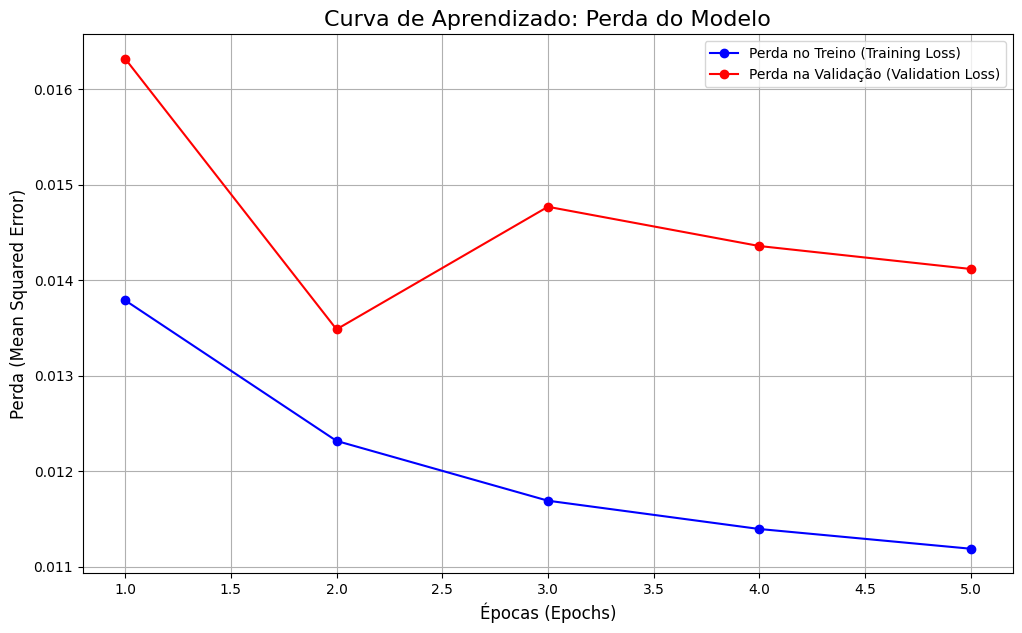

In [ ]:
import matplotlib.pyplot as plt

# --- Resgata os dados do histórico de treinamento ---
perda_treino = historico.history['loss']
perda_validacao = historico.history['val_loss']
epocas = range(1, len(perda_treino) + 1)

# --- Cria o Gráfico ---
plt.figure(figsize=(12, 7))

# Plota a curva de perda do treino
plt.plot(epocas, perda_treino, 'bo-', label='Perda no Treino (Training Loss)')

# Plota a curva de perda da validação
plt.plot(epocas, perda_validacao, 'ro-', label='Perda na Validação (Validation Loss)')

# --- Configurações do Gráfico ---
plt.title('Curva de Aprendizado: Perda do Modelo', fontsize=16)
plt.xlabel('Épocas (Epochs)', fontsize=12)
plt.ylabel('Perda (Mean Squared Error)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()